# Trial with mapping
## important changes:
- use zookeper.py from my branch!!!
- __ getitem__ function changed
- forward changed
- check the path for '../artifacts' because I changed it

In [1]:
import optuna
from tqdm import tqdm
import logging
import sys
import torch
import os
from datetime import datetime
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#import torch.utils.data
#from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split, Dataset, DataLoader
from PIL import Image
import zookeeper as zk  # convool_size & mappy
import pickle  # for artifact, maybe not useful

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/home/margherita/src/ambiente/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


import shutil
    
data = pd.read_csv('../data/og/training_solutions_rev1.csv')
test = data.sample(frac=.1)
train = data.drop(test.index)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.to_csv('../data/training/training_solutions_rev1.csv', index_label=False)
test.to_csv('../data/test/test_solutions_rev1.csv', index_label=False)

for image in (train.GalaxyID.astype('string') + '.jpg').values:
    shutil.move(os.path.join('../data/og/', image), os.path.join('../data/training/', image))

for image in (test.GalaxyID.astype('string') + '.jpg').values:
    shutil.move(os.path.join('../data/og/', image), os.path.join('../data/test/', image))

train.head()


pd.read_csv('../data/test/test_solutions_rev1.csv').shape[0] + pd.read_csv('../data/training/training_solutions_rev1.csv').shape[0]


In [ ]:
class GalaxyJungle(Dataset):
    #the init function initializes the directory containing the image,
    #the annotations file,
    #and both transforms
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, is_rgb=False):
        self.rgb = is_rgb
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    #returns number of samples in the dataset
    def __len__(self):
        return (self.img_labels).shape[0]

    #loads a sample from the dataset
     ############### MAPPED TARGET LABELS
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])) + '.jpg'
        #retrieves the image
        image = Image.open(img_path)
        if not self.rgb: image = image.convert('L')
        #retrieves corresponding label
        label = self.img_labels.iloc[idx, 1:]
        #if possible, transform the image and the label into a tensor.
        if self.transform:
            image = self.transform(image)#.type(torch.float16)
        label=torch.tensor(label.to_numpy(), dtype=torch.float32, requires_grad=False) #cambiato in to_numpy perchè label.values restituisce un metodo e non un valore. In alternativa label.values() meno version proof
        label = zk.mappy(label)#.detach().clone()
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, self.img_labels.iloc[idx, 0]


transfs = transforms.Compose([
    transforms.ToTensor(), # Riscala le immagini tra 0 e 1
    transforms.CenterCrop(324),
    transforms.Resize(128),
    transforms.RandomRotation(180)
    ])

DS = GalaxyJungle('../data/training/training_solutions_rev1.csv', '../data/training/', transfs)
training, test = random_split(DS, [.8, .2])
x=DS.__getitem__(0)
print(x[1].shape)

In [3]:
class GalaxyNet(nn.Module):
    def __init__(self, activation, initialization=False, is_rgb=False):
        super().__init__()
        
        rgb = 3 if is_rgb else 1
        input_size = 128
        num_labels = 37
        
        self.loss_dict = {'batch' : [], 'epoch' : [], 'vbatch' : [], 'vepoch' : []}
        self.activation = activation

        
        ## convolutional layers
        self.convs = nn.Sequential(
            nn.Conv2d(rgb, 16, 3, bias=False),
            nn.BatchNorm2d(16),
            self.activation(),
            

            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 16, 3, bias=False),
            nn.BatchNorm2d(16),
            self.activation(),

            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, bias=False),
            nn.BatchNorm2d(32),
            self.activation(),
            

            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, bias=False),
            nn.BatchNorm2d(64),
            self.activation(),
            

            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, bias=False),
            nn.BatchNorm2d(128),
            self.activation(),
                               

            nn.MaxPool2d(2)
            )

        for layer in self.convs:
            if layer.__class__.__name__ == 'Conv2d': input_size = zk.convool_size(input_size, 3, 1)
            elif layer.__class__.__name__ == 'MaxPool2d': input_size = zk.convool_size(input_size, 2, 2)

        if input_size < 2: raise ValueError('You shrank too much dude.')
        print(f'Convs output size: {input_size}')

        input_linear = 128 * input_size * input_size
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_linear, 100),
            self.activation(),
            nn.Linear(100, num_labels)
            )
        
        if initialization: self.init_weights()



    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x)
        x= zk.mappy2D(x)
        #print('After mappy:', x.shape)
        return x


    def init_weights(self):
        if self.activation == nn.ReLU:
            nonlin = 'relu'
            a = 0
        elif self.activation == nn.LeakyReLU:
            nonlin = 'leaky_relu'
            a = .01
        
        # Init convolutional parameters
        for layer in self.convs: 
            if layer.__class__.__name__ == 'Conv2d': nn.init.kaiming_normal_(layer.weight, a=a, nonlinearity=nonlin)
        

        # Init linear parameters
        for i in (1, -1): nn.init.constant_(self.fc[i].bias, 0)
        nn.init.kaiming_normal_(self.fc[1].weight, a=a, nonlinearity=nonlin)
        nn.init.xavier_uniform_(self.fc[-1].weight)      
        


    def log_the_loss(self, item,epoch=False): # per avere una history della loss???
        verbose=False
        train = self.__getstate__()['training']
        if verbose: print(train)
        if epoch and train:
            self.loss_dict['epoch'].append(item) ### get state of the model so you can ditch the validation parameter
        elif not epoch and train:
            self.loss_dict['batch'].append(item)
        elif not train and epoch:
            self.loss_dict['vepoch'].append(item)
        elif not train and not epoch:
            self.loss_dict['vbatch'].append(item)
        return item


In [4]:
def one_epoch_train(model, train_loader, optimizer, loss_function, verbose=False):
    running_loss = 0
    model.train()
    for i, data in tqdm(enumerate(train_loader)):
        inputs,labels, _ = data
        inputs,labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss=loss_function(outputs, labels)
        loss.backward()
        optimizer.step() # fa update del parameter
        RMSEloss = np.sqrt(loss.item())
        running_loss += RMSEloss
        if verbose and i%10 ==0: print(f'Batch {i+1}/{len(train_loader)} - Loss: {RMSEloss:.3f}')

        model.log_the_loss(RMSEloss, epoch=False)
    epochmean_loss = running_loss / len(train_loader)
    print(f'\nLoss: {epochmean_loss}')
    model.log_the_loss(epochmean_loss, epoch=True)
    last_loss = RMSEloss
    print(f"Last loss: {last_loss}")
    return epochmean_loss



def one_epoch_eval(model, test_loader, loss_function, verbose=False):
    model.eval()
    running_validation_loss = 0.
   
    with torch.no_grad(): # deactivates gradient evaluation
        for i, vdata in tqdm(enumerate(test_loader)):
            inputs,labels, _ = vdata
            inputs,labels= inputs.to(device), labels.to(device)
            outputs = model(inputs)#, activation=F.relu)
            loss = loss_function(outputs ,labels)
            RMSEloss = np.sqrt(loss.item())
            running_validation_loss += RMSEloss
            model.log_the_loss(RMSEloss,epoch=False)
    mean_vloss=model.log_the_loss(running_validation_loss / len(test_loader),epoch=True)
    print(f"Validation Loss: {mean_vloss}\n---")
    return mean_vloss

In [5]:
DS = GalaxyJungle('../data/training/training_solutions_rev1.csv', '../data/training/', transfs)
training, test = random_split(DS, [.8, .2])

# MODEL LOAD + NEW TRAINING

In [36]:
model = pd.read_pickle('../artifacts/4ec97088-5fca-463c-a02b-a8d92f855242')
#print(model)

In [ ]:
## CAMBIARE CON I PARAMETRI DEL MODELLO TROVATI DA OPTUNA
model = model
learning_rate = 0.0008509005973164451
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100
loss_function = nn.MSELoss()
train_loader = DataLoader(training, batch_size=32, shuffle=True, num_workers=os.cpu_count())
test_loader = DataLoader(test, batch_size=32, shuffle=False, num_workers=os.cpu_count())
for epoch in range(epochs):
    print(f'Training epoch {epoch}')
    one_epoch_train(model, train_loader, optimizer, loss_function, verbose=False)
    
    print(f'Validation epoch {epoch}')
    epoch_last_val_loss = one_epoch_eval(model, test_loader, loss_function, verbose=False)
    if epoch%10==0:
        torch.save({
        'model_state_dict': model.state_dict(),
        'optim_state_dict': optimizer.state_dict(),
        }, f'../models/model_{epoch}.pt')

        torch.save(model.loss_dict, f'model_{epoch}.pyd')



189


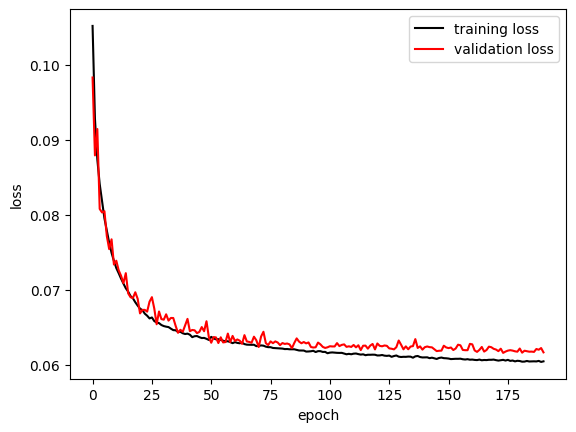

In [37]:
#torch.serialization.add_safe_globals([np._core.multiarray.scalar])
x = torch.load('../models/fixed/model_190.pyd',weights_only=False)

#x.keys()

#print(len(x['batch'])) # loss di ogni minibatch del training
#print(len(x['epoch'])) # loss media per epoca
#print(len(x['vbatch'])) #del validation loss per ogni minibatch
#print(len(x['vepoch'])) # validation loss media per epoca

plt.plot(x['epoch'], label='training loss', c='k')
plt.plot(x['vepoch'], label='validation loss', c='r')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
print(np.argmin(x['epoch']))

In [41]:
#optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "JAGZooNet"
storage_name = "sqlite:///{}.db".format(study_name)

from optuna_dashboard import run_server
run_server(storage_name)

Bottle v0.13.3 server starting up (using WSGIRefServer())...
Listening on http://localhost:8080/
Hit Ctrl-C to quit.

127.0.0.1 - - [28/May/2025 19:09:59] "GET / HTTP/1.1" 302 0
127.0.0.1 - - [28/May/2025 19:09:59] "GET /dashboard HTTP/1.1" 200 4145
127.0.0.1 - - [28/May/2025 19:09:59] "GET /static/bundle.js HTTP/1.1" 304 0
127.0.0.1 - - [28/May/2025 19:10:00] "GET /favicon.ico HTTP/1.1" 200 7670
127.0.0.1 - - [28/May/2025 19:10:00] "GET /api/studies HTTP/1.1" 200 137
/home/margherita/src/ambiente/lib/python3.12/site-packages/optuna_dashboard/_importance.py:96: ExperimentalWarning: PedAnovaImportanceEvaluator is experimental (supported from v3.6.0). The interface can change in the future.
  study, target=target, evaluator=PedAnovaImportanceEvaluator()
/home/margherita/src/ambiente/lib/python3.12/site-packages/optuna/importance/_ped_anova/evaluator.py:150: UserWarning: PedAnovaImportanceEvaluator computes the importances of params to achieve low `target` values. If this is not what you 